**Task**

Apply polynomial regression on the dataset [bottle.csv](https://www.kaggle.com/datasets/sohier/calcofi?select=bottle.csv), varying the polynomial degree from 1 to 6. Running the program should produce two graphs: one showing all data points from the dataset and all 6 regression curves in 2D, and another displaying the dependency of the final cost function on the entire dataset (not in the last training epoch) on the polynomial degree. What can we observe? Discuss in the comment below the code.

**The goal is to predict water temperature based on salinity information about the dataset is here.**

X - salinity column, Y - water temperature column

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
# Data preprocessing
file_path = 'bottle.csv'
data = pd.read_csv(file_path, usecols=['Salnty', 'T_degC'])

data = data.dropna()                                # clean null values
data = data.reset_index(drop=True)
data_700 = data.iloc[:700]                          # first 700 rows

data_700 = data_700.sample(frac=1).reset_index(drop=True)   # shuffle

# Normalization
for column in data_700.columns:
    data_700[column] = (data_700[column] - np.mean(data_700[column])) / np.std(data_700[column])

num_rows, num_columns = data_700.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)
print(data_700.head(n=5), '\n')

X = data_700['Salnty'].astype('float32')
Y = data_700['T_degC'].astype('float32')

Number of rows: 700
Number of columns: 2
     T_degC    Salnty
0  1.009626 -1.359301
1 -0.204454  0.342882
2  1.120590 -1.264735
3  0.112121  0.322077
4  1.068372 -1.397127 



Epoch: 5/10| Avg loss: 0.20773
Epoch: 10/10| Avg loss: 0.20764
Gotov za polinom stepena 1
Epoch: 5/10| Avg loss: 0.14354
Epoch: 10/10| Avg loss: 0.13459
Gotov za polinom stepena 2
Epoch: 5/10| Avg loss: 0.16508
Epoch: 10/10| Avg loss: 0.12448
Gotov za polinom stepena 3
Epoch: 5/10| Avg loss: 0.14774
Epoch: 10/10| Avg loss: 0.12331
Gotov za polinom stepena 4
Epoch: 5/10| Avg loss: 0.13349
Epoch: 10/10| Avg loss: 0.12592
Gotov za polinom stepena 5
Epoch: 5/10| Avg loss: 0.14274
Epoch: 10/10| Avg loss: 0.12527
Gotov za polinom stepena 6


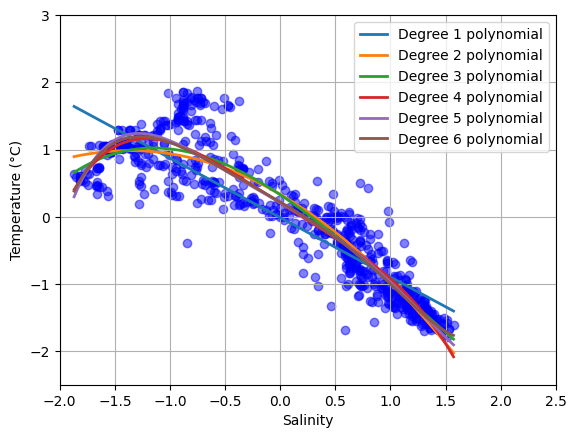

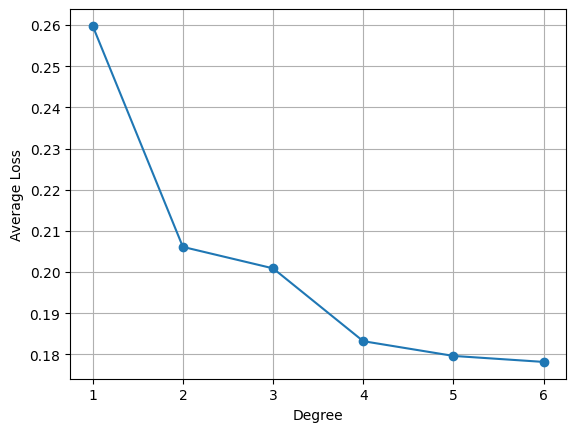

In [ ]:
# X matrix
def create_feature_matrix(x, nb_features):
  tmp_features = []
  for deg in range(1, nb_features+1):
    tmp_features.append(np.power(x, deg))
  return np.column_stack(tmp_features)

# Predicition
def pred(x, w, b):
    w_col = tf.reshape(w, (nb_features, 1))
    hyp = tf.add(tf.matmul(x, w_col), b)
    return hyp

# Loss function
def loss(x, y, w, b):
    prediction = pred(x, w, b)
    y_col = tf.reshape(y, (-1, 1))
    mse = tf.reduce_mean(tf.square(prediction - y_col))
    loss = mse
    return loss

# Gradient calculation
def calc_grad(x, y, w, b):
    with tf.GradientTape() as tape:
        loss_val = loss(x, y, w, b)              # loss_val = scalar tensor

    w_grad, b_grad = tape.gradient(loss_val, [w, b])
    return w_grad, b_grad, loss_val

# Training step
def train_step(x, y, w, b, adam):
    w_grad, b_grad, loss = calc_grad(x, y, w, b)

    adam.apply_gradients(zip([w_grad, b_grad], [w, b]))

    return loss

# Main part of the code
polynom_degrees = 6

learning_rate = 0.001
nb_epochs = 10

# Plots
plt_rcurve, ax_rcurve = plt.subplots()
plt_loss, ax_loss = plt.subplots()

# Store losses for every epoch
losses = [[] for _ in range(polynom_degrees)]

for nb_features in range(1, polynom_degrees + 1):

    adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    feature_matrix = create_feature_matrix(X, nb_features)

    # Model parameters
    w = tf.Variable(tf.zeros(nb_features))
    b = tf.Variable(0.0)

    # Training loop
    for epoch in range(nb_epochs):

        # Stochastic Gradient Descent
        epoch_loss = 0
        nb_samples = X.shape[0]
        for sample in range(nb_samples):
            x = feature_matrix[sample].reshape((1, nb_features))
            y = Y[sample]

            curr_loss = train_step(x, y, w, b, adam)
            epoch_loss += curr_loss

        epoch_loss /= nb_samples
        losses[nb_features - 1].append(epoch_loss)
        if (epoch + 1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{nb_epochs}| Avg loss: {epoch_loss:.5f}')

    # Print message when training is done for the current polynomial degree
    print(f'Over for polynomial of degree {nb_features}')

    # Generate predictions using the trained model
    x_values = np.linspace(min(X), max(X), 100).reshape(-1, 1)
    feature_matrix = create_feature_matrix(x_values, nb_features)
    y_values = np.dot(feature_matrix, w.numpy()) + b.numpy()

    # Plot the regression curve
    ax_rcurve.plot(x_values, y_values, label=f'Degree {nb_features} polynomial', linewidth=2)

# Regression curve plot - add points
ax_rcurve.scatter(X, Y, c='blue', alpha=0.5)
ax_rcurve.set_xlabel('Salinity')
ax_rcurve.set_ylabel('Temperature (°C)')
ax_rcurve.set_xlim([-2, 2.5])
ax_rcurve.set_ylim([-2.5, 3])
ax_rcurve.grid(True)
ax_rcurve.legend()
plt_rcurve.show()

# Loss plot
average_losses = [sum(loss) / len(loss) if loss else 0 for loss in losses]

# Plot
plt.plot(range(1, len(average_losses) + 1), average_losses, linestyle='-', marker='o')
plt.xlabel('Degree')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

**Conclusion**

On the graph of the final cost function, a decreasing curve was observed. It appears that the fourth-degree polynomial is the most favorable choice, as it is the last point before a pronounced decrease in slope. Under ideal conditions, a pronounced elbow in the curve would be expected.